In [11]:
import os
import re
from typing import Dict

import mne
import numpy as np
import scipy.stats as sp_stats
from joblib import Parallel, delayed
from NirsLabProject.config.paths import Paths

from NirsLabProject.utils import pipeline_utils as putils
from NirsLabProject.config.consts import *

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.utils import sleeping_utils
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils.group_spikes import group_spikes
from NirsLabProject.utils import plotting

In [2]:
def has_sleeping_data(subj):
    flat_features = np.load(subj.paths.subject_flat_features_path)
    hypnogram = flat_features[:, HYPNOGRAM_FLAG_INDEX]
    return not np.isnan(hypnogram.sum())

detection_subjects = putils.get_subjects(
    filters=[
        lambda subj: os.path.exists(subj.paths.subject_flat_features_path),
        lambda subj: not subj.stimuli_project,
        lambda subj: has_sleeping_data(subj)
    ],
    sort_key=lambda subj: subj.p_number,
)

In [55]:
import matplotlib.pyplot as plt

def create_box_plot_for_stimuli(figure_path: str, data_channels: Dict[str, np.array], data_channels_linear: Dict[str, np.array], feature_name: str, show: bool = False):
    fig, ax = plt.subplots(figsize=(8, 4))
    data = []
    for key, values in data_channels.items():
        data.append([value for value in values])

    # add horizontal line at y=0
    ax.axhline(y=0, color='black', linewidth=1, zorder=1)
    # Boxplot data
    bp = ax.boxplot(
        x=data,
        vert=True,
        patch_artist=True,
        zorder=2,
        showfliers=False
    )

    # change the color of the boxplots
    box_plots_colors = ['lightseagreen', 'indianred', 'royalblue']
    box_plots_edges_colors = ['darkcyan', 'firebrick', 'navy']
    for idx, patch in enumerate(bp['boxes']):
        patch.set_facecolor(box_plots_colors[idx])
        patch.set_alpha(0.8)
        patch.set_edgecolor(box_plots_edges_colors[idx])

    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
    
    # add al points as scatter plot next to the boxplot
    for channel, values in data_channels_linear.items():
        points = [v for v in values]
        ax.plot(range(1,len(points)+1), points, 'ro-', alpha=0.5, linewidth=0.6, color='black')

    # x axis ticks
    if len(data) == len(data_channels):
        plt.xticks(np.arange(1, len(data_channels) + 1, 1), data_channels.keys())
    else:
        plt.xticks(np.arange(1, 2 * len(data_channels), 2) + 0.5, data_channels.keys())

    # y axis ticks
    plt.ylabel('spikes/minutes')

    # title
    plt.title(f"{feature_name}")   

    # fig.savefig(
    #     fname=os.path.join(figure_path, feature_name),
    #     bbox_inches='tight',
    #     dpi=300
    # )

    if show:
        plt.show()

subject 396 stage nrem spikes rate 26.59090909090909 spikes 7605 duration 4.766666666666667 hours
subject 396 stage wake spikes rate 26.2875 spikes 2103 duration 1.3333333333333333 hours
subject 396 stage rem spikes rate 16.0 spikes 424 duration 0.44166666666666665 hours
subject 398 stage nrem spikes rate 26.0 spikes 5629 duration 3.6083333333333334 hours
subject 398 stage wake spikes rate 75.57142857142857 spikes 1587 duration 0.35 hours
subject 398 stage rem spikes rate 7.8125 spikes 250 duration 0.5333333333333333 hours
subject 402 stage nrem spikes rate 10.31578947368421 spikes 2352 duration 3.8 hours
subject 402 stage wake spikes rate 14.105263157894736 spikes 1206 duration 1.425 hours
subject 402 stage rem spikes rate 0.8679245283018868 spikes 46 duration 0.8833333333333333 hours
subject 406 stage nrem spikes rate 50.05185185185185 spikes 13514 duration 4.5 hours
subject 406 stage wake spikes rate 74.32335329341318 spikes 6206 duration 1.3916666666666666 hours
subject 406 stage r

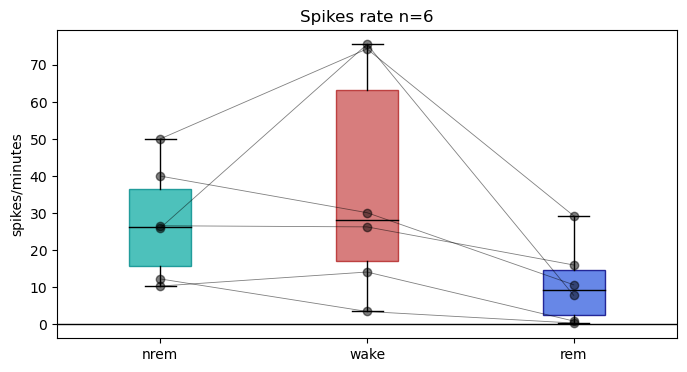

In [56]:
class SleepStage:
    def __init__(self, stage):
        self.stage = stage
        self.duration = 0
        self.spikes = 0
    
    def add_spike(self):
        self.spikes += 1
    
    def add_duration(self, start_time, end_time):
        self.duration += (end_time - start_time)

    @property
    def dureation_in_seconds(self):
        return self.duration / 1000
    
    @property
    def spikes_rate(self):
        return self.spikes / (self.dureation_in_seconds / 60)


def calcualte_spikes_rate(subj):
    flat_features = np.load(s.paths.subject_flat_features_path)
    utils.add_sleeping_stage_flag_to_spike_features(subj, flat_features, separate_wake_and_rem=True)
    group_ids = flat_features[:, GROUP_INDEX]
    unique_indices = np.unique(group_ids, return_index=True)[1]
    unique_group_subj_features = flat_features[unique_indices]
    hypnogram = unique_group_subj_features[:, HYPNOGRAM_FLAG_INDEX]

    subj_stages = {
        stage: SleepStage(stage) for stage in DETECTION_HYPNOGRAM_FALGS_NAMES.values()
    }
    for h in hypnogram:
        stage = DETECTION_HYPNOGRAM_FALGS_NAMES[h]
        subj_stages[stage].add_spike()

    changing_points, values = sleeping_utils.get_hypnogram_changes_in_miliseconds(subj, separate_wake_and_rem=True)
    for i in range(len(changing_points)-1):
        start_time = changing_points[i]
        end_time = changing_points[i+1]
        stage = DETECTION_HYPNOGRAM_FALGS_NAMES[values[i]]
        subj_stages[stage].add_duration(start_time, end_time)

    for stage, stage_data in subj_stages.items():
        print(f"subject {subj.p_number} stage {stage} spikes rate {stage_data.spikes_rate} spikes {stage_data.spikes} duration {stage_data.dureation_in_seconds / 3600} hours")

    
    return subj_stages


subject_stages = {}
stages = {
    stage: [] for stage in DETECTION_HYPNOGRAM_FALGS_NAMES.values()
}
for s in detection_subjects:
    subj_stages = calcualte_spikes_rate(s)
    subject_stages[s.p_number] = {}
    for stage, stage_data in subj_stages.items():
        stages[stage].append(stage_data.spikes_rate)
        subject_stages[s.p_number] = [stage_data.spikes_rate for stage_data in subj_stages.values()]

create_box_plot_for_stimuli(
    figure_path="",
    data_channels=stages,
    data_channels_linear=subject_stages,
    feature_name=f'Spikes rate n={len(detection_subjects)}',
    show=True
)
    
